In [2]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

Create data frame of annotation info

In [3]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_30Hz.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(959, 13)
Int64Index([], dtype='int64')
(959, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,27027.176,0.425917,10837.547405,5707.476688,-0.126823,0.377957,0.002312,10295.670035
1,1,527,cagepair,24750.0,low slug,37908.195,0.398388,11494.421472,20341.214122,2.260426,6.039381,0.000276,10919.700398
2,2,527,cagepair,56002.5,bbc,58470.477,0.269287,24073.796354,457414.435489,2.212847,4.058525,0.052721,22870.106536
3,3,527,cagepair,174352.5,bbc,25419.660,0.412652,12492.389958,36344.717351,4.486549,24.826529,0.010252,11867.770460
4,4,527,cagepair,342877.5,bbc,89444.420,0.202590,20286.532473,118454.584002,0.756532,-0.899343,0.026989,19272.205849


In [ ]:
annot_features_full.Annotation.value_counts()

In [4]:
annot_features_lowslug = annot_features_full[(annot_features_full['Annotation'] == 'rand_noise') | (annot_features_full['Annotation'] == 'low slug')]
annot_features_lowslug.shape

(860, 13)

In [5]:
#separate and save for later testing dataset
train_orig, test_orig = train_test_split(annot_features_lowslug, test_size=0.3, random_state=1, stratify = annot_features_lowslug.Annotation)

In [6]:
train_orig_maj = train_orig[train_orig['Annotation'] == 'rand_noise']
train_orig_min = train_orig[train_orig['Annotation'] != 'rand_noise']

train_orig_min_upsamples = resample(train_orig_min, replace=True, n_samples = len(train_orig_maj), random_state = 123)

train_orig_upsamples = pd.concat([train_orig_min_upsamples, train_orig_maj])

print(train_orig_upsamples.Annotation.value_counts())

train_orig_upsamples.head()

low slug      560
rand_noise    560
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
45,45,535,CPApair,163980.0,low slug,35348.957,0.223821,10867.930515,91977.608822,3.282584,10.113040,-0.003652,10324.533989
53,53,535,CPApair,268065.0,low slug,50627.387,0.269204,11023.450405,41737.574470,2.151645,4.040161,-0.003362,10472.277885
121,121,555,CPApair,260842.5,low slug,31200.697,0.268231,11295.602564,76691.495896,3.143920,9.218403,-0.002429,10730.822436
16,16,533,CPApair,149692.5,low slug,15738.608,0.336482,16232.895546,110694.181447,2.796368,7.935559,0.010795,15421.250769
17,17,533,CPApair,243157.5,low slug,240681.800,0.056371,10601.016031,137642.627165,3.188586,9.205500,-0.007020,10070.965230


In [7]:
groups = train_orig_upsamples['Unnamed: 0'].values
annot_labels_up = train_orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'low slug': 1, 'rand_noise': 0})
print(annot_labels_up.value_counts())

1    560
0    560
Name: Annotation, dtype: int64


In [8]:
annot_features_up = train_orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
annot_features_up.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
45,35348.957,0.223821,10867.930515,91977.608822,3.282584,10.113040,-0.003652,10324.533989
53,50627.387,0.269204,11023.450405,41737.574470,2.151645,4.040161,-0.003362,10472.277885
121,31200.697,0.268231,11295.602564,76691.495896,3.143920,9.218403,-0.002429,10730.822436
16,15738.608,0.336482,16232.895546,110694.181447,2.796368,7.935559,0.010795,15421.250769
17,240681.800,0.056371,10601.016031,137642.627165,3.188586,9.205500,-0.007020,10070.965230


In [9]:
group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(annot_features_up, annot_labels_up, groups))

In [10]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

In [11]:
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=10, random_state=0)
svm_cv = SVC(probability=True) 

In [12]:
y_pred_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(annot_labels_up, y_pred_lr)
conf_mat_lr

array([[501,  59],
       [ 84, 476]], dtype=int64)

In [13]:
y_pred_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(annot_labels_up, y_pred_rf)
conf_mat_rf

array([[550,  10],
       [210, 350]], dtype=int64)

In [14]:
y_pred_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, features_scaled, annot_labels_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(annot_labels_up, y_pred_svm)
conf_mat_svm

array([[529,  31],
       [113, 447]], dtype=int64)

In [15]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_lr, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_lr, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_lr))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_lr, average='weighted'))

Sensitivity/Recall (TPR):  0.8723214285714286
Precision (PPV):  0.8730649412892404
Accuracy:  0.8723214285714286
F1: 0.8722577814998703


In [16]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_rf, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_rf, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_rf))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_rf, average='weighted'))

Sensitivity/Recall (TPR):  0.8035714285714286
Precision (PPV):  0.847953216374269
Accuracy:  0.8035714285714286
F1: 0.7971014492753623


In [17]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(annot_labels_up,y_pred_svm, average='weighted'))
print("Precision (PPV): ", metrics.precision_score(annot_labels_up,y_pred_svm, average='weighted'))
print("Accuracy: ", metrics.accuracy_score(annot_labels_up,y_pred_svm))
print("F1:", metrics.f1_score(annot_labels_up,y_pred_svm, average='weighted'))

Sensitivity/Recall (TPR):  0.8714285714285714
Precision (PPV):  0.8795669912277272
Accuracy:  0.8714285714285714
F1: 0.870735671760938


In [18]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(annot_labels_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.9133609693877552
Random forest ROC_AUC:  0.8699521683673469
SVM ROC_AUC:  0.8655420918367347


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

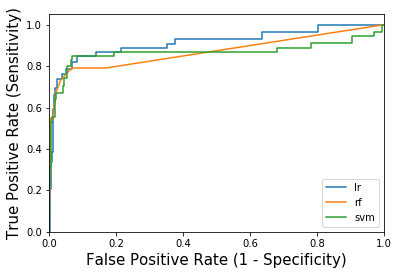

In [19]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(annot_labels_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(annot_labels_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(annot_labels_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

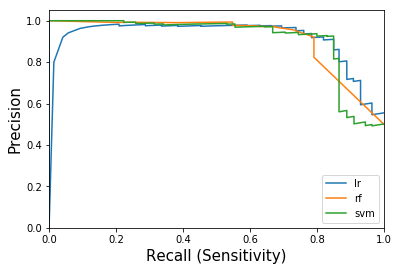

In [20]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(annot_labels_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

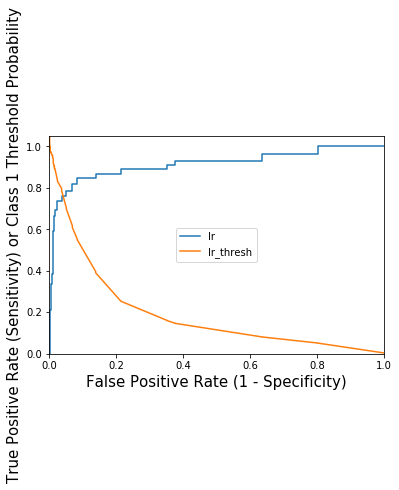

In [21]:
# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_lr, thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [22]:
train_orig_upsamples['pred_lr'] = y_pred_prob_lr[:,1]
train_orig_upsamples['pred_rf'] = y_pred_prob_rf[:,1]
train_orig_upsamples['pred_svm'] = y_pred_prob_svm[:,1]
train_orig_upsamples['class_actual'] = annot_labels_up
train_orig_upsamples['class_lr'] = y_pred_lr
train_orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,pred_lr,pred_rf,pred_svm,class_actual,class_lr
45,45,535,CPApair,163980.0,low slug,35348.957,0.223821,10867.930515,91977.608822,3.282584,10.113040,-0.003652,10324.533989,0.944105,0.9,0.981197,1,1
53,53,535,CPApair,268065.0,low slug,50627.387,0.269204,11023.450405,41737.574470,2.151645,4.040161,-0.003362,10472.277885,0.696796,0.0,0.649254,1,1
121,121,555,CPApair,260842.5,low slug,31200.697,0.268231,11295.602564,76691.495896,3.143920,9.218403,-0.002429,10730.822436,0.929194,0.9,0.974057,1,1
16,16,533,CPApair,149692.5,low slug,15738.608,0.336482,16232.895546,110694.181447,2.796368,7.935559,0.010795,15421.250769,0.940316,0.5,0.994686,1,1
17,17,533,CPApair,243157.5,low slug,240681.800,0.056371,10601.016031,137642.627165,3.188586,9.205500,-0.007020,10070.965230,0.979280,0.4,0.938867,1,1


In [23]:
train_orig_upsamples.groupby('Annotation')['pred_lr', 'pred_rf', 'pred_svm'].describe()

pred_lr                                                                       pred_rf                                              pred_svm                                                                      
             count      mean       std       min       25%       50%       75%       max   count      mean       std  min  25%  50%  75%  max    count      mean       std       min       25%       50%       75%       max
Annotation                                                                                                                                                                                                                  
low slug     560.0  0.793268  0.291664  0.050630  0.786083  0.933045  0.972522  0.999149   560.0  0.608065  0.379163  0.0  0.3  0.8  0.9  1.0    560.0  0.771762  0.324995  0.036698  0.649254  0.950248  0.985644  0.999982
rand_noise   560.0  0.190301  0.210442  0.002909  0.058662  0.110606  0.229018  0.999921   560.0  0.037840  0.118326  0.0  0.0  0.0  0.0  1.0    560.0  0.154438  0.183409  0.018232  0.071434  0.100798  0.133287  0.988992

In [24]:
preds = []
for index, row in train_orig_upsamples.iterrows():
    if (row['class_actual'] == 0) & (row['class_lr'] == 0):
        pred = 'TN'
    if (row['class_actual'] == 0) & (row['class_lr'] == 1):
        pred = 'FP'
    if (row['class_actual'] == 1) & (row['class_lr'] == 1):
        pred = 'TP'
    if (row['class_actual'] == 1) & (row['class_lr'] == 0):
        pred = 'FN'
    preds.append(pred)
    
train_orig_upsamples['pred'] = preds

In [25]:
train_orig_upsamples.groupby('pred').describe()

Unnamed: 0                                                           animal_number                                                           time_stamp                                                                                  power_sum                                                                                        spec_pur                                                                       spec_cent                                                                                                  spec_spread                                                                                                       spec_skew                                                                       spec_kurt                                                                        spec_slope                                                                       spec_roll                                                                                                 pred_lr  \
          count        mean         std   min    25%    50%    75%    max         count        mean        std    min    25%    50%    75%    max      count           mean            std      min       25%       50%         75%       max     count          mean            std        min        25%        50%        75%           max    count      mean       std       min       25%       50%       75%       max     count          mean          std           min           25%           50%           75%           max       count           mean            std           min           25%           50%            75%            max     count      mean       std       min       25%       50%       75%       max     count      mean       std       min       25%       50%       75%        max      count      mean       std       min       25%       50%       75%       max     count          mean          std          min           25%           50%           75%           max   count   
pred                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
FN         84.0   69.833333   22.748935  44.0   51.0   61.0   95.0  100.0          84.0  540.869048   7.202375  535.0  535.0  537.5  543.0  553.0       84.0  197246.517857   72804.128182  88920.0  163800.0  168435.0  263244.375  270945.0      84.0  20042.741286    8178.512206  10866.320  12565.957  18668.121  29290.902  3.081633e+04     84.0  0.394940  0.057279  0.292281  0.381105  0.385744  0.415749  0.476229      84.0  13604.991818  2123.498878  10061.369191  12846.010118  13024.018058  14985.647530  17333.599864        84.0   23633.319896   12705.855422   6217.209550  15253.241780  23567.294467   30735.094796   49177.659927      84.0  0.630046  0.296523  0.167070  0.554564  0.717789  0.803247  1.113127      84.0  0.378272  0.977733 -0.688786 -0.674554 -0.099281  0.702675   1.939307       84.0  0.007376  0.006280 -0.000621 -0.000115  0.009818  0.010146  0.018012      84.0  12924.742228  2017.323934  9558.300732  12203.709612  12372.817155  14236.365154  16466.919871    84.0   
FP         59.0  361.694915  

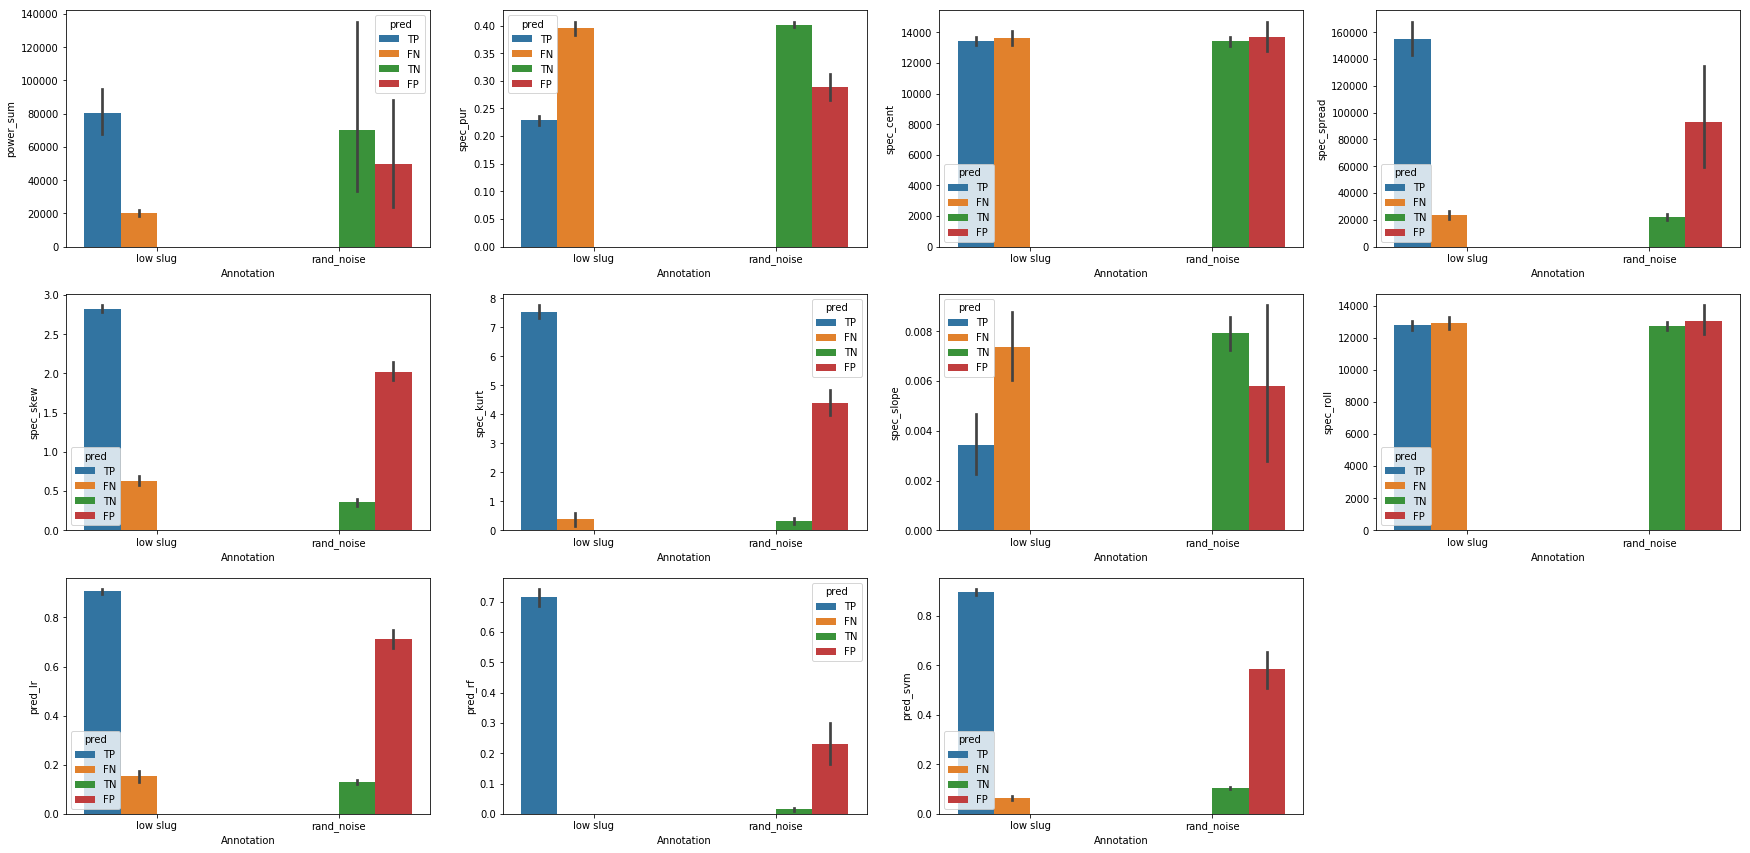

In [26]:
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_lr', 'pred_rf',
       'pred_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_orig_upsamples)
    i = i + 1

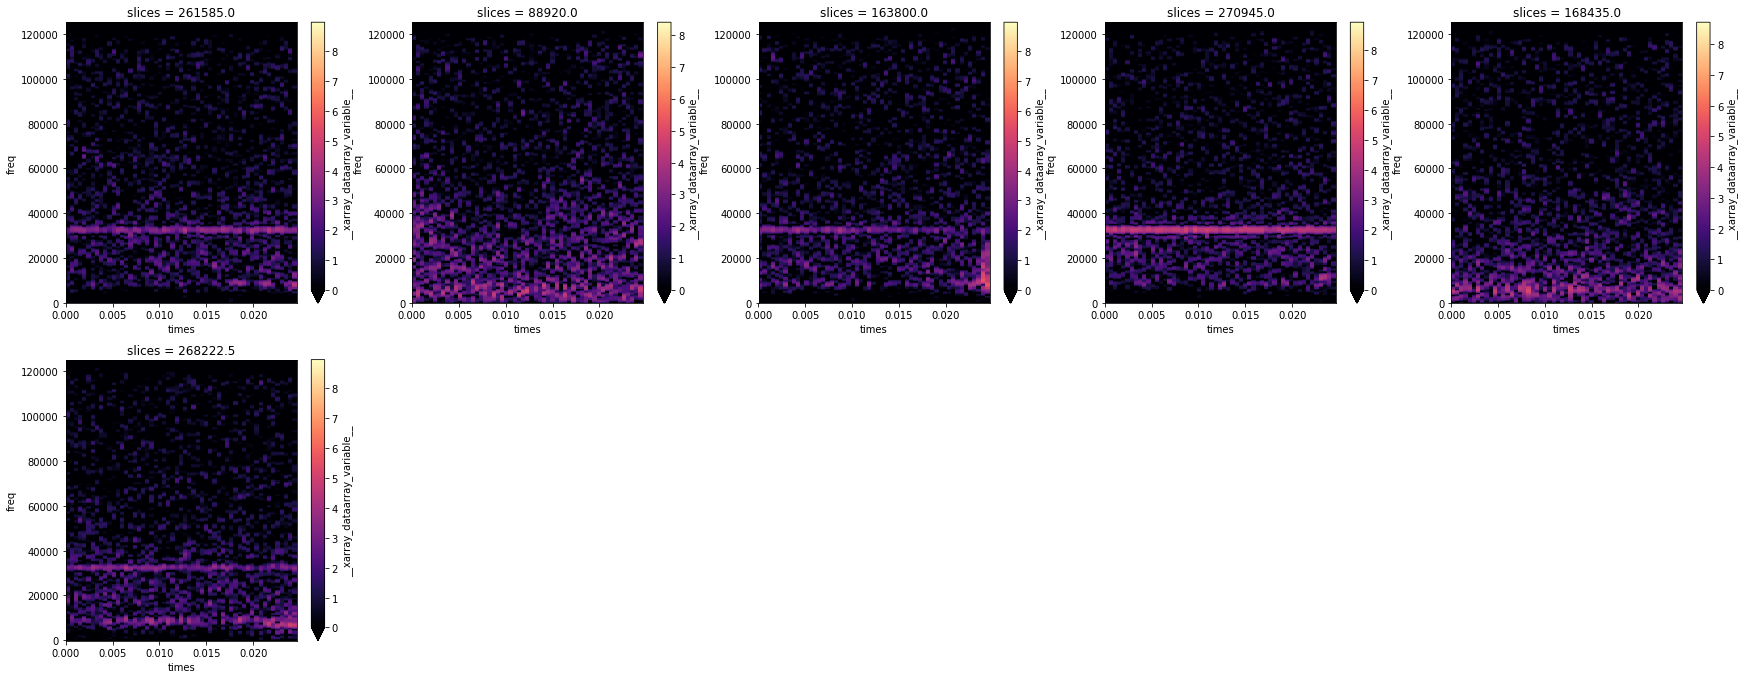

In [27]:
false_neg_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FN'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(5, 5, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

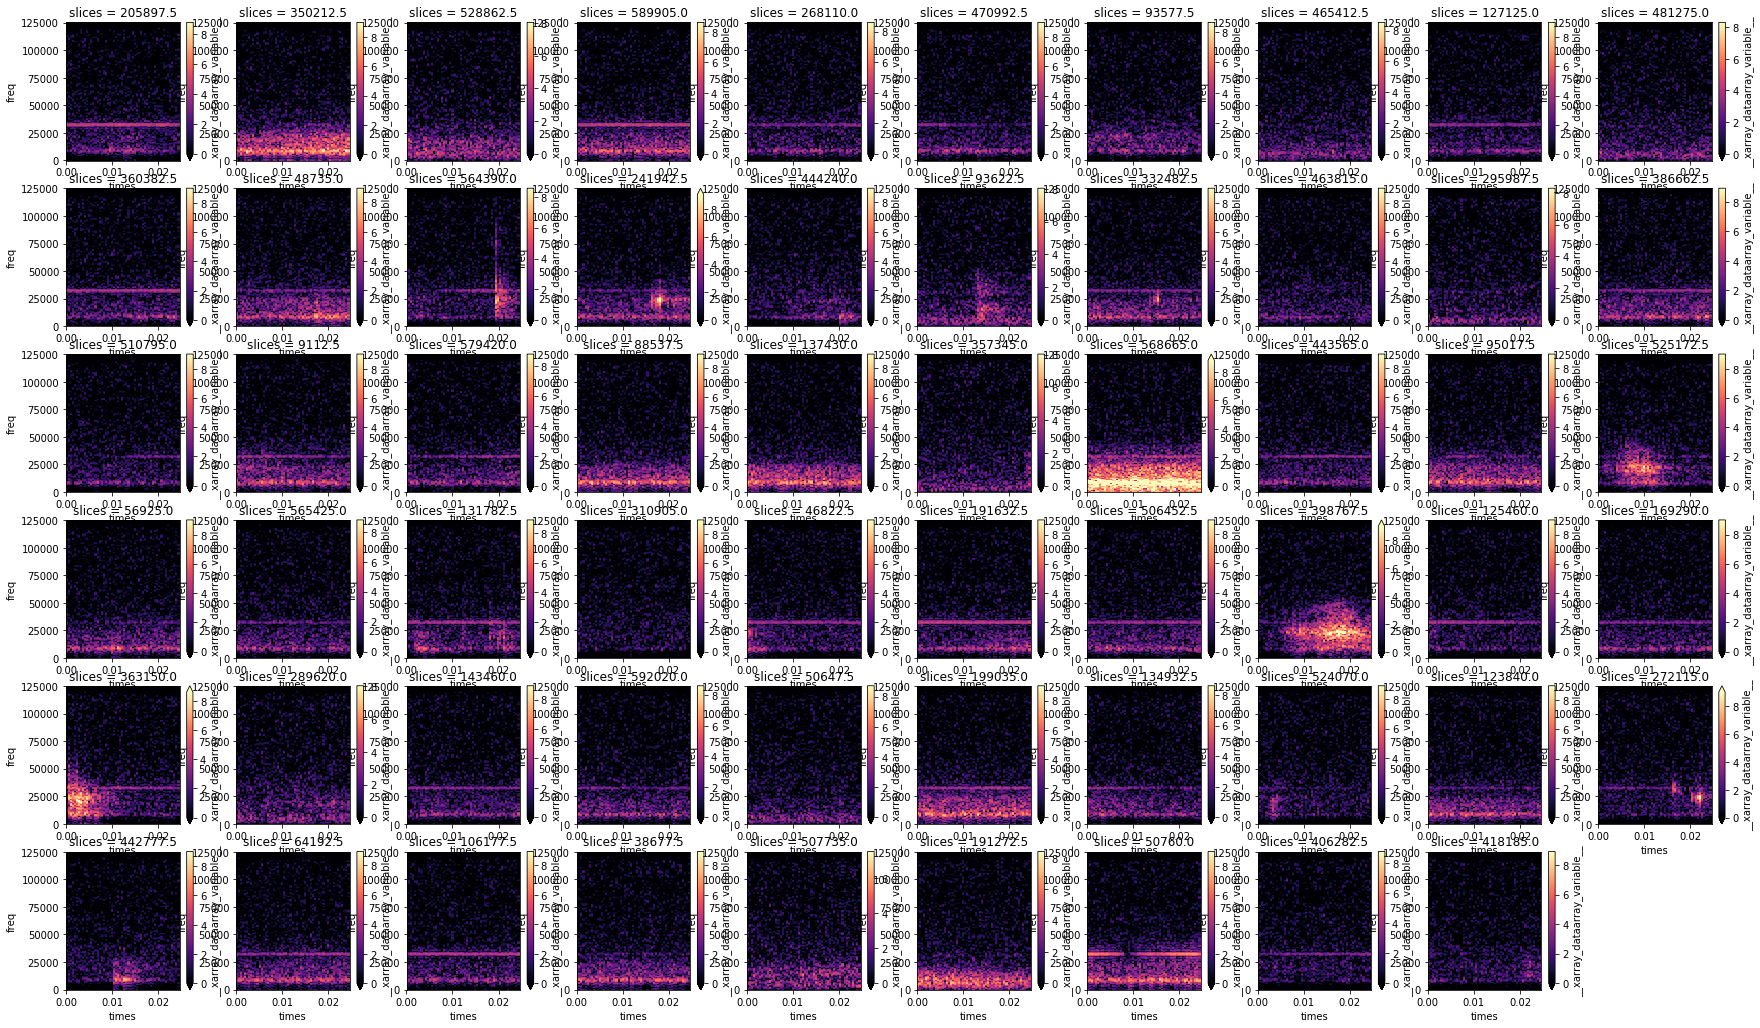

In [29]:
false_pos_unique = train_orig_upsamples[train_orig_upsamples['pred'] == 'FP'].drop_duplicates()
i = 1
plt.figure(figsize=(30,30))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(10, 10, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1